In this notebook, I want to see how the use of different notions of similarity, is at a larger level.
I will use laplacian eigenmap (cuz it's spectral, therefore less noise vectors wise) to create embeddings of networks (well separated SBM to begin with) with 2 (3, and 4) clusters. If I use euclidean distance or cosine or dot similarity between each (non-redundant) pair of vectors, how does the distribution look? 


1. Create Networks

In [1]:
import numpy as np
import networkx as nx
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Generate SBM Network
n_communities = 2
size = 2000
p_intra = 0.1
p_inter = 0.04
sizes = [size // n_communities] * n_communities
p_matrix = np.full((n_communities, n_communities), p_inter)
np.fill_diagonal(p_matrix, p_intra)

G = nx.stochastic_block_model(sizes, p_matrix)
true_labels = [i for i, s in enumerate(sizes) for _ in range(s)]

community_table = pd.DataFrame({'community_id': true_labels})

/tmp/ipykernel_2644429/3569483843.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('rainbow', n_communities)


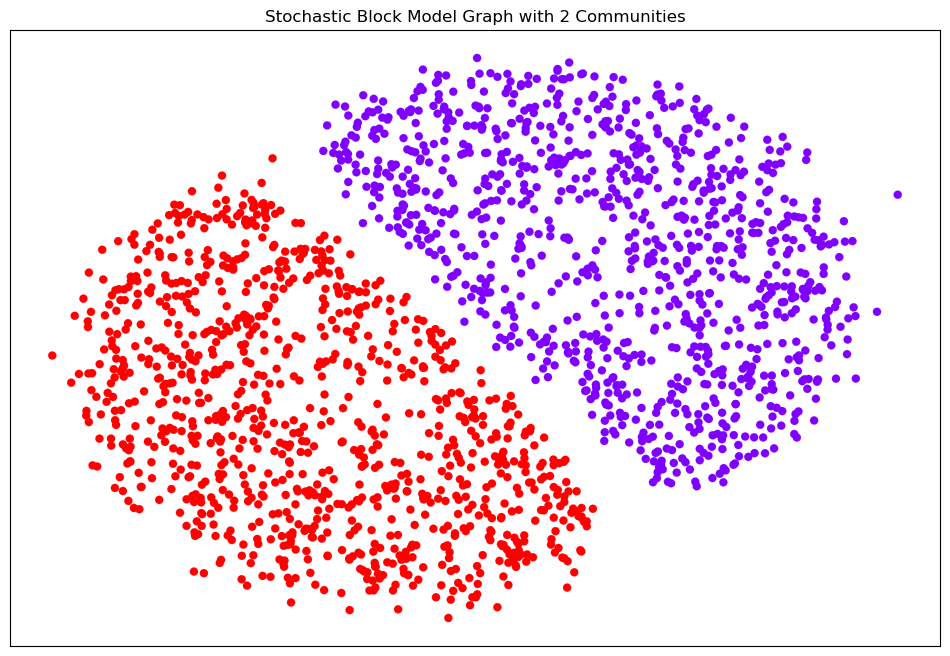

In [2]:
# Generalized plotting based on n_communities
import matplotlib.cm as cm

def plot_graph_with_communities(G, true_labels, n_communities):
    pos = nx.spring_layout(G)  # Position nodes using spring layout
    plt.figure(figsize=(12, 8))

    # Assign a color to each community using a colormap
    cmap = cm.get_cmap('rainbow', n_communities)
    colors = [cmap(label) for label in true_labels]

    # Draw the graph
    nx.draw_networkx_nodes(G, pos, node_color=colors, node_size=35, linewidths=0.1)
    #nx.draw_networkx_edges(G, pos, alpha=0.5)
    plt.title(f'Stochastic Block Model Graph with {n_communities} Communities')
    plt.show()

# Plot the generalized graph with n_communities
plot_graph_with_communities(G, true_labels, n_communities)

2. Get Laplacian Eigenmap embeddings

In [3]:
import sys
sys.path.append("/nobackup/gogandhi/alt_means_sans_k/")
from scripts.nets_and_embeddings import *
emb = create_embedding(G, emb_params = {
                                    "method": "leigenmap",
                                    "window_length": 10,
                                    "walk_length": 80, #30,
                                    "num_walks": 10, #200,
                                    "dim" : n_communities-1 #128,
                                        })
normalized_emb = emb / np.linalg.norm(emb, axis=1, keepdims=True)



3. Calculate and lower triangular matrix of pairwise distances

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform


def compute_node_distances(arr):
    """
    Computes the Euclidean distance, cosine similarity, and dot product similarity
    between all pairs of nodes, while avoiding redundant calculations.
    
    Parameters:
        arr (numpy.ndarray): Array of shape (2000, 64), where each row corresponds to a node.
    
    Returns:
        dict: A dictionary containing pairwise Euclidean distances, cosine similarities, and dot products.
    """

    # Euclidean distances (only unique pairs)
    euclidean_distances = pdist(arr, metric='euclidean')
    
    # Cosine similarities (only unique pairs)
    cosine_similarities = pdist(arr, metric='cosine')
    
    # Convert cosine distance to similarity (1 - cosine distance)
    cosine_similarities = 1 - cosine_similarities
    
    # Dot product similarities
    dot_similarities = pdist(arr, metric=lambda u, v: np.dot(u, v))
    
    return {
        'euclidean_distances': euclidean_distances,
        'cosine_similarities': cosine_similarities,
        'dot_similarities': dot_similarities
    }


import numpy as np

def condensed_index(i, j, n):
    """
    Convert the indices (i, j) from a squareform matrix to a condensed form index.
    The formula for converting squareform index to condensed index:
        k = n * i - i * (i + 1) // 2 + j - i - 1
    where i < j.

    Parameters:
        i (int): Row index.
        j (int): Column index.
        n (int): Number of nodes.

    Returns:
        int: Index in condensed matrix.
    """
    if i == j:
        raise ValueError("i and j should not be the same")
    if i > j:
        i, j = j, i
    return n * i - i * (i + 1) // 2 + (j - i - 1)

def filter_condensed_distances(community_labels, condensed_distances):
    """
    Filter the condensed distance vector to retain only the distances between nodes in the same community.
    
    Parameters:
        community_labels (np.array): Array of community labels for each node.
        condensed_distances (np.array): 1D condensed distance vector from pdist.
    
    Returns:
        np.array: Filtered condensed distance vector.
    """
    n = len(community_labels)
    filtered_distances = []

    # Loop through the upper triangular part of the matrix (i < j)
    for i in range(n):
        for j in range(i + 1, n):
            if community_labels[i] == community_labels[j]:
                # Get the corresponding condensed index
                condensed_idx = condensed_index(i, j, n)
                # Append the distance at this index to the filtered list
                filtered_distances.append(condensed_distances[condensed_idx])
    
    return np.array(filtered_distances)

In [32]:
import matplotlib.pyplot as plt

def plot_distributions(euclidean, cosine, dot):
    # Plot all three distributions in the same plot
    plt.figure(figsize=(12, 4))
    plt.hist(euclidean, bins=50, alpha=0.5, label='Euclidean Distance', color='blue', weights=np.ones_like(euclidean) / len(euclidean))
    plt.hist(cosine, bins=50, alpha=0.5, label='Cosine Similarity', color='green', weights=np.ones_like(cosine) / len(cosine))
    plt.hist(dot, bins=50, alpha=0.5, label='Dot Product Similarity', color='red', weights=np.ones_like(dot) / len(dot))
    plt.legend(loc='upper right')
    plt.title('Distribution of Euclidean Distance, Cosine Similarity, and Dot Product Similarity')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.show()

    # Separate plots for each distribution
    plt.figure(figsize=(12, 4))
    
    # Euclidean distance distribution
    plt.subplot(1, 3, 1)
    plt.hist(euclidean, bins=50, color='blue', alpha=0.7, weights=np.ones_like(euclidean) / len(euclidean))
    plt.title('Euclidean Distance')
    plt.xlabel('Value')
    plt.ylabel('Frequency')

    # Cosine similarity distribution
    plt.subplot(1, 3, 2)
    plt.hist(cosine, bins=50, color='green', alpha=0.7,weights=np.ones_like(cosine) / len(cosine))
    plt.title('Cosine Similarity')
    plt.xlabel('Value')
    plt.ylabel('Frequency')

    # Dot product similarity distribution
    plt.subplot(1, 3, 3)
    plt.hist(dot, bins=50, color='red', alpha=0.7,weights=np.ones_like(dot) / len(dot))
    plt.title('Dot Product Similarity')
    plt.xlabel('Value')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()


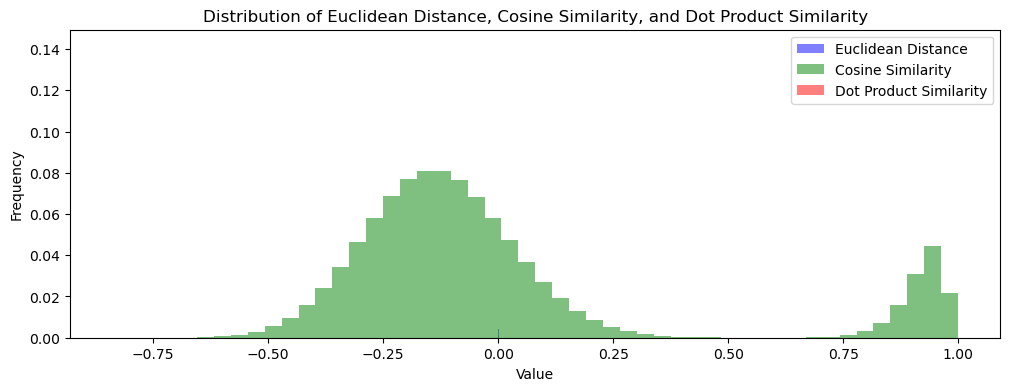

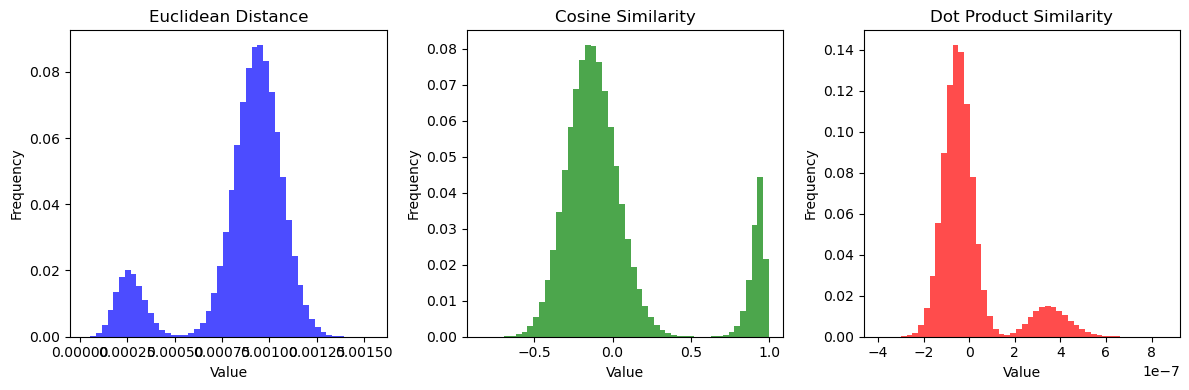

In [33]:
distances = compute_node_distances(emb)

plot_distributions(distances['euclidean_distances'], 
                   distances['cosine_similarities'], 
                   distances['dot_similarities'])

4. Plot


In [34]:
# Step 1: Generate SBM Network
n_communities = 2
size = 1000*n_communities
p_intra = 0.1
p_inter = 0.04
sizes = [size // n_communities] * n_communities
p_matrix = np.full((n_communities, n_communities), p_inter)
np.fill_diagonal(p_matrix, p_intra)

G = nx.stochastic_block_model(sizes, p_matrix)
true_labels = [i for i, s in enumerate(sizes) for _ in range(s)]

community_table = pd.DataFrame({'community_id': true_labels})

In [37]:
sizes # Each community has 1000 nodes in a community, even if we keep p_intra and p_inter same,
# we need to ensure the number of nodes in each communtiy is the same as we increase the number of communities

[1000, 1000]

#### Embeddings generated through Node2Vec (Not Normalized, which is the default everywhere else)

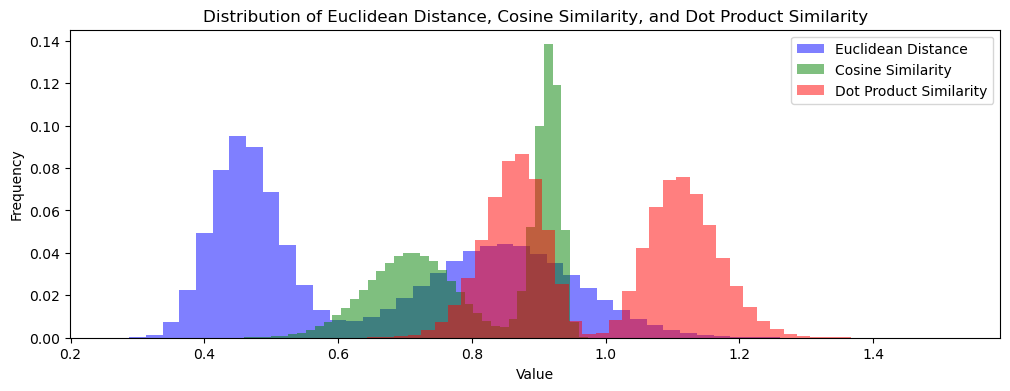

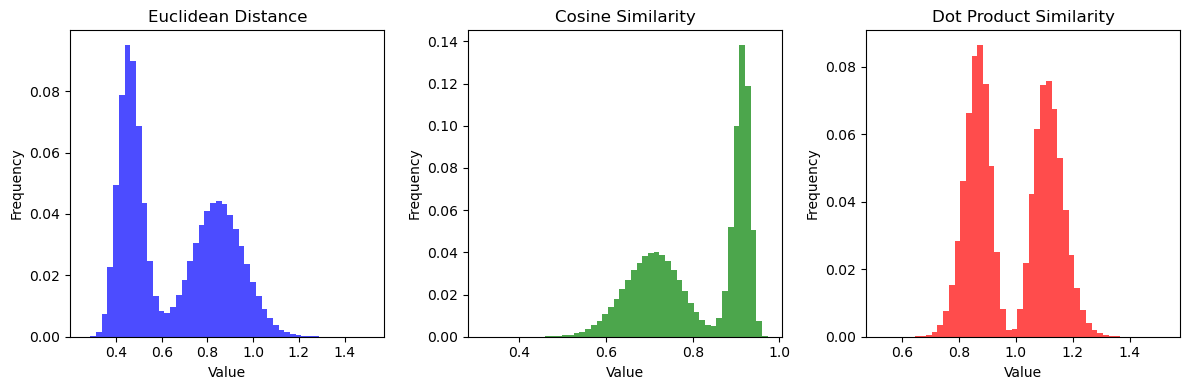

In [38]:
emb = create_embedding(G, emb_params = {
                                    "method": "node2vec",
                                    "window_length": 10,
                                    "walk_length": 80, #30,
                                    "num_walks": 10, #200,
                                    "dim" : 64 #128,
                                        })
normalized_emb = emb / np.linalg.norm(emb, axis=1, keepdims=True)

distances = compute_node_distances(emb)

plot_distributions(distances['euclidean_distances'], 
                   distances['cosine_similarities'], 
                   distances['dot_similarities'])

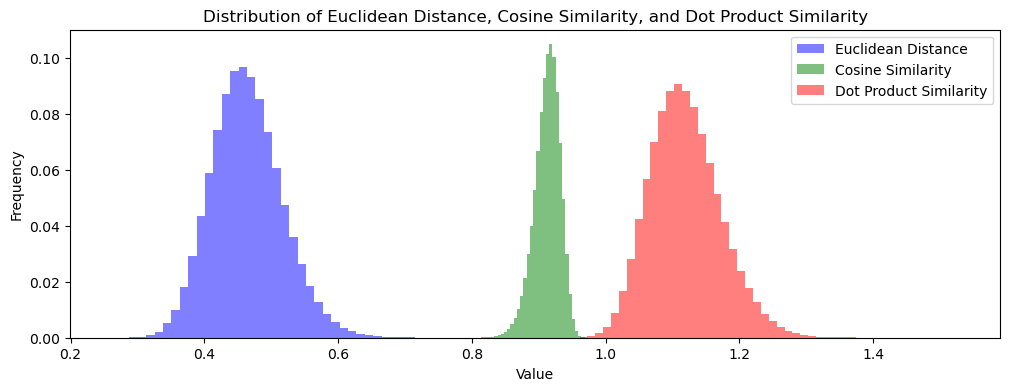

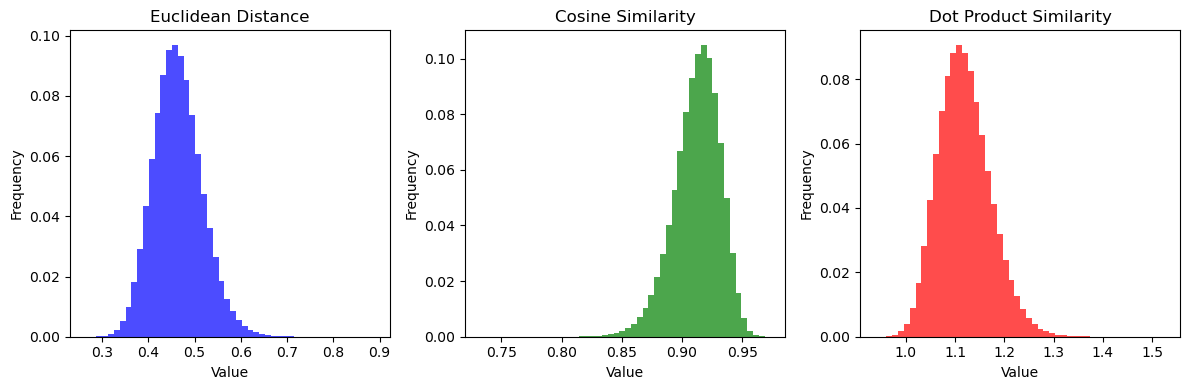

In [41]:
community_labels = community_table['community_id'].values

# Get the filtered distances for each metric
euclidean_distances_filtered = filter_condensed_distances(community_labels, distances['euclidean_distances'])
cosine_similarities_filtered = filter_condensed_distances(community_labels, distances['cosine_similarities'])
dot_similarities_filtered = filter_condensed_distances(community_labels, distances['dot_similarities'])

# Now call your original plot_distributions function to plot the filtered distances
plot_distributions(euclidean_distances_filtered,
                   cosine_similarities_filtered,
                   dot_similarities_filtered)


#### Embeddings generated through Node2Vec (Normalized)

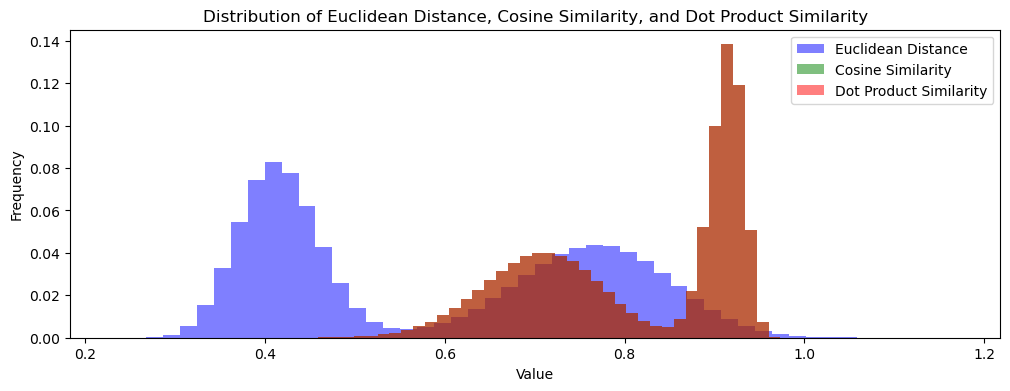

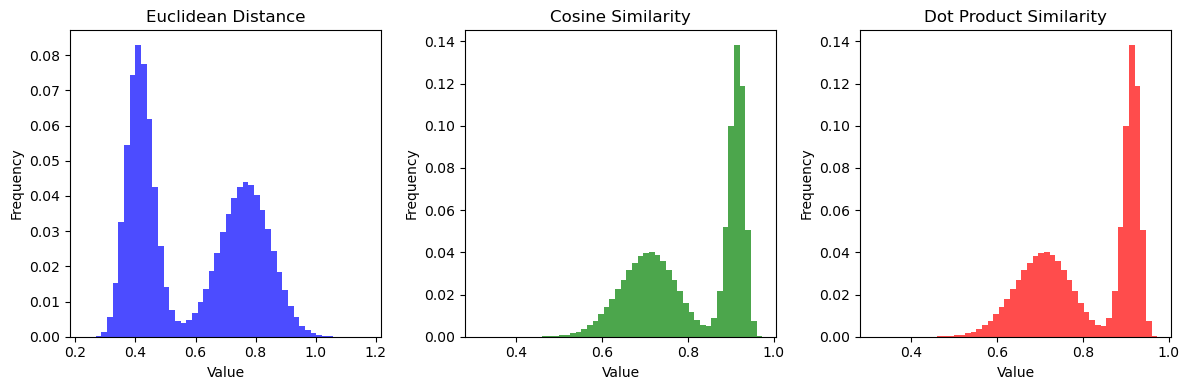

In [42]:
distances = compute_node_distances(normalized_emb)

plot_distributions(distances['euclidean_distances'], 
                   distances['cosine_similarities'], 
                   distances['dot_similarities'])

#### Embeddings generated through Laplacian Eigenmap

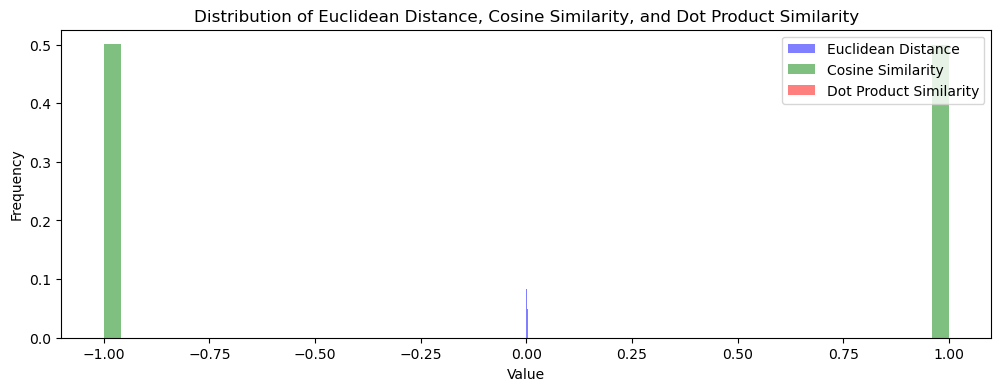

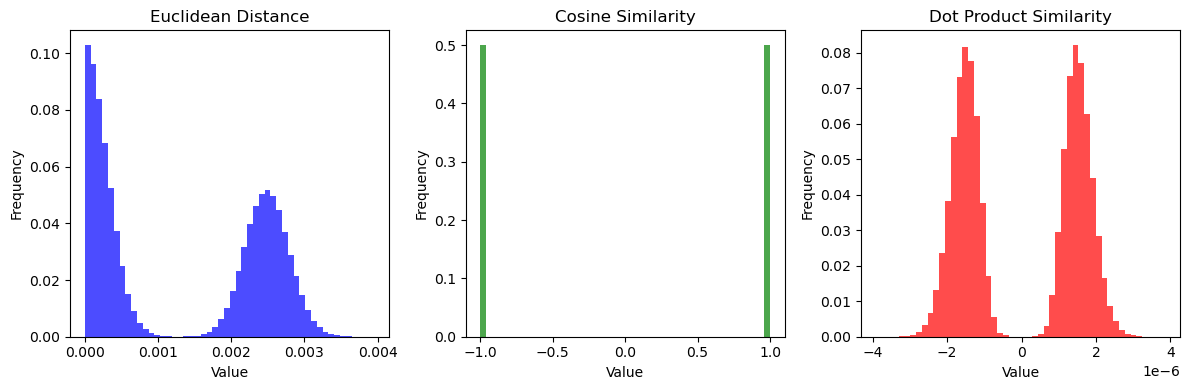

In [10]:
emb = create_embedding(G, emb_params = {
                                    "method": "leigenmap",
                                    "window_length": 10,
                                    "walk_length": 80, #30,
                                    "num_walks": 10, #200,
                                    "dim" : n_communities-1 #128,
                                        })
normalized_emb = emb / np.linalg.norm(emb, axis=1, keepdims=True)

distances = compute_node_distances(emb)

plot_distributions(distances['euclidean_distances'], 
                   distances['cosine_similarities'], 
                   distances['dot_similarities'])

There is a remarkable difference in using node2vec vs laplacian eigenmap. Here we use laplacian eigenmap and the well separated distribution is gone. And all metrics are identical in their shape, even if they are not normalized. The dot similarity and Euclidean distance distribution is extremely sharp tailed. (Barely visible in the big plot)

What about looking at the pairwise distances of nodes belonging to the same commmunity?

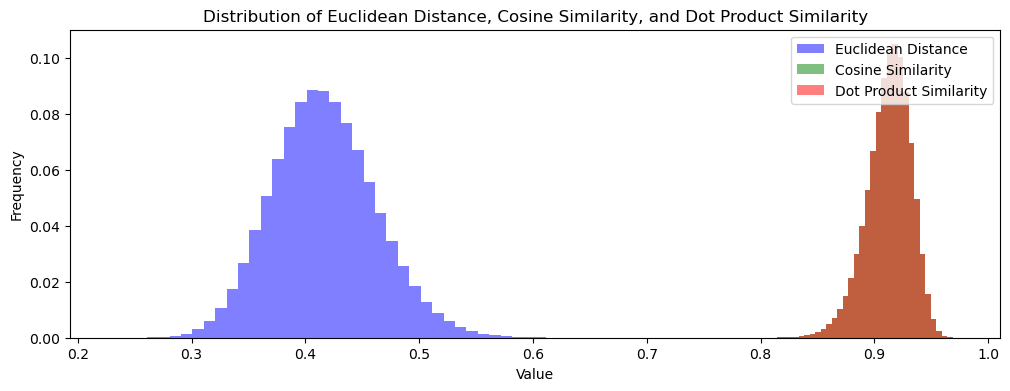

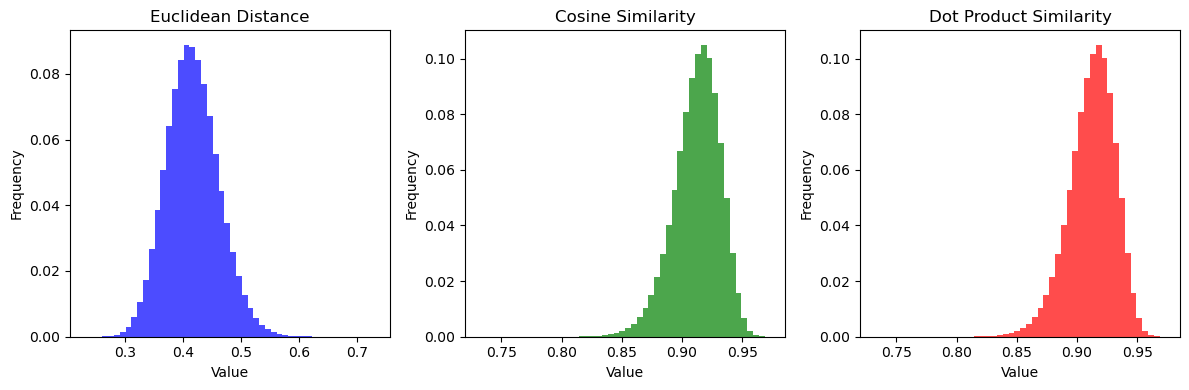

In [43]:


# Get the filtered distances for each metric
euclidean_distances_filtered = filter_condensed_distances(community_labels, distances['euclidean_distances'])
cosine_similarities_filtered = filter_condensed_distances(community_labels, distances['cosine_similarities'])
dot_similarities_filtered = filter_condensed_distances(community_labels, distances['dot_similarities'])

# Now call your original plot_distributions function to plot the filtered distances
plot_distributions(euclidean_distances_filtered,
                   cosine_similarities_filtered,
                   dot_similarities_filtered)


## Analysis for 4 well separated clusters

#### Embeddings generated through Node2Vec

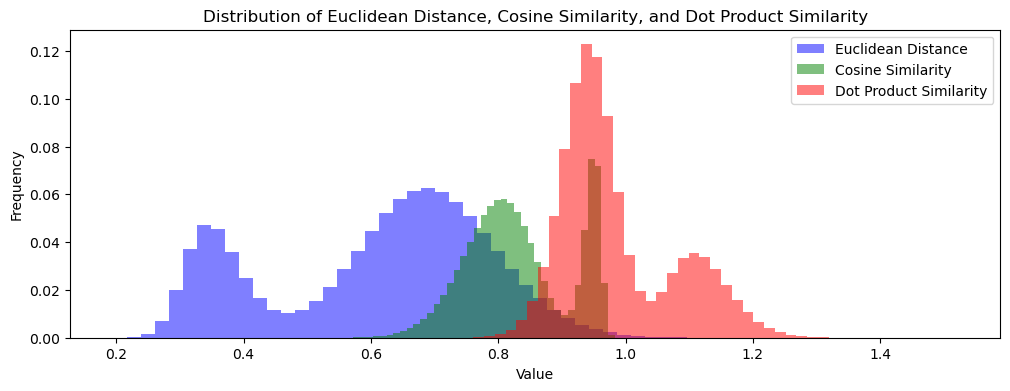

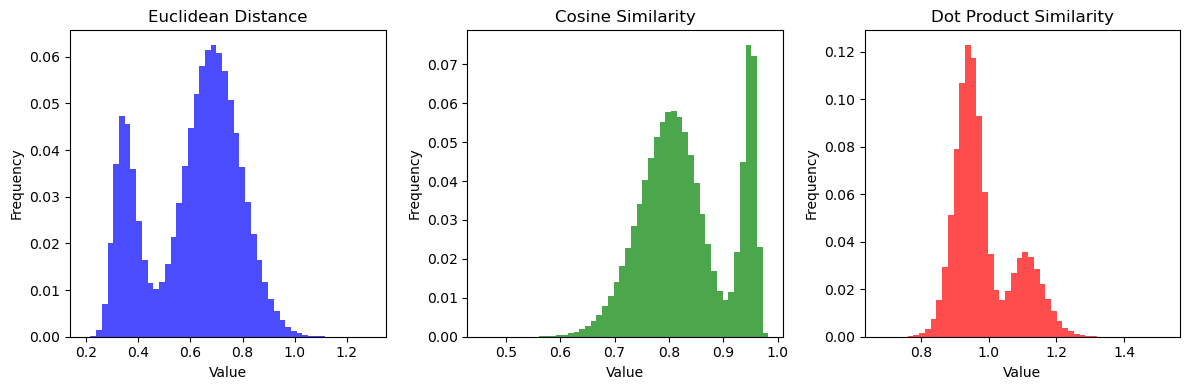

In [44]:
# Step 1: Generate SBM Network
n_communities = 4
size = 1000*n_communities

p_intra = 0.1
p_inter = 0.04
sizes = [size // n_communities] * n_communities
p_matrix = np.full((n_communities, n_communities), p_inter)
np.fill_diagonal(p_matrix, p_intra)

G = nx.stochastic_block_model(sizes, p_matrix)
true_labels = [i for i, s in enumerate(sizes) for _ in range(s)]

community_table = pd.DataFrame({'community_id': true_labels})

emb = create_embedding(G, emb_params = {
                                    "method": "node2vec",
                                    "window_length": 10,
                                    "walk_length": 80, #30,
                                    "num_walks": 10, #200,
                                    "dim" : 64 #128,
                                        })
normalized_emb = emb / np.linalg.norm(emb, axis=1, keepdims=True)

distances = compute_node_distances(emb)

plot_distributions(distances['euclidean_distances'], 
                   distances['cosine_similarities'], 
                   distances['dot_similarities'])

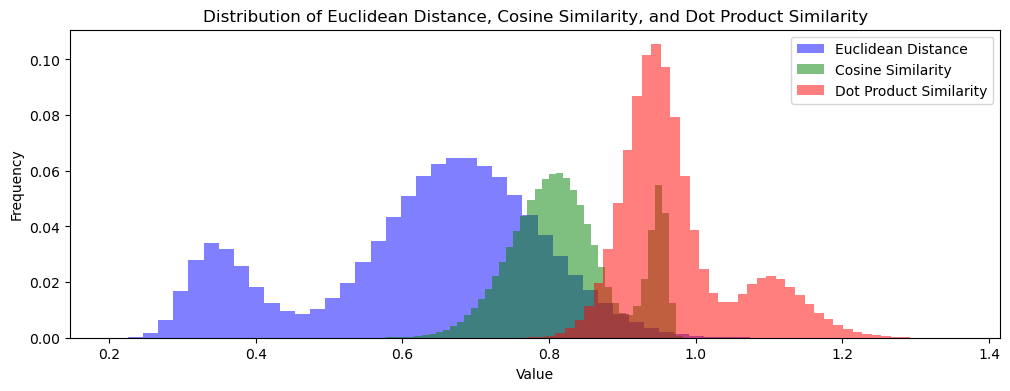

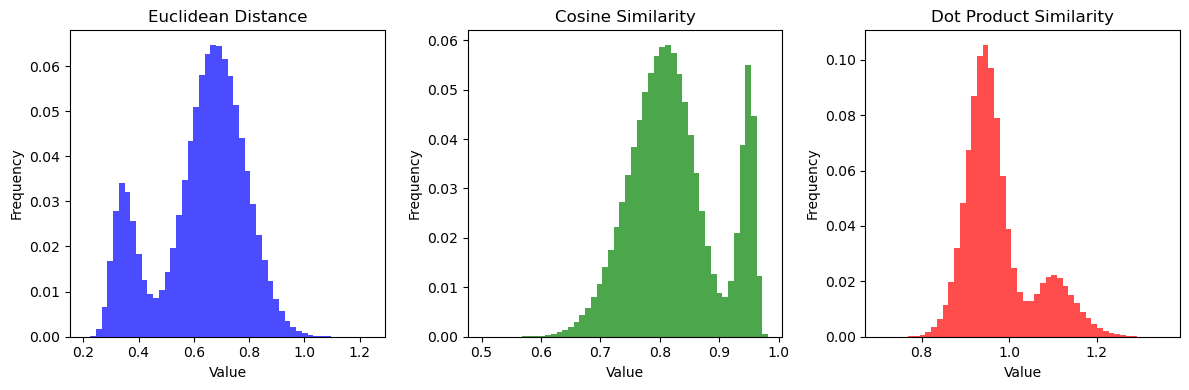

In [45]:


# Get the filtered distances for each metric
euclidean_distances_filtered = filter_condensed_distances(community_labels, distances['euclidean_distances'])
cosine_similarities_filtered = filter_condensed_distances(community_labels, distances['cosine_similarities'])
dot_similarities_filtered = filter_condensed_distances(community_labels, distances['dot_similarities'])

# Now call your original plot_distributions function to plot the filtered distances
plot_distributions(euclidean_distances_filtered,
                   cosine_similarities_filtered,
                   dot_similarities_filtered)


#### Embeddings generated through Laplacian Eigenmap

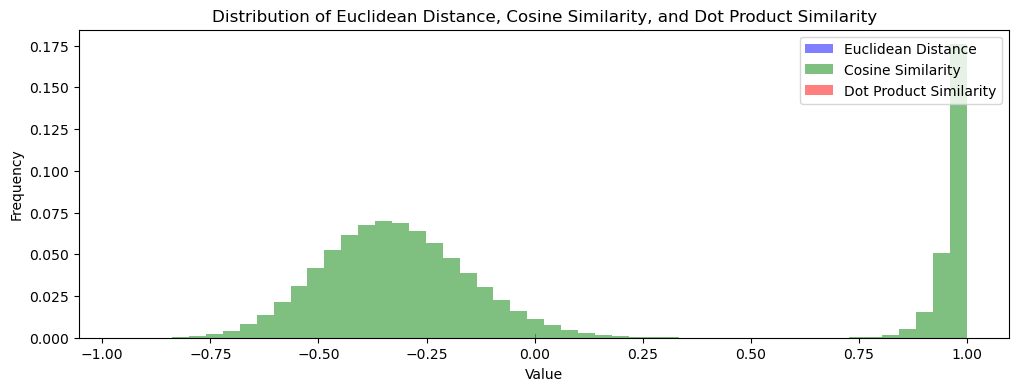

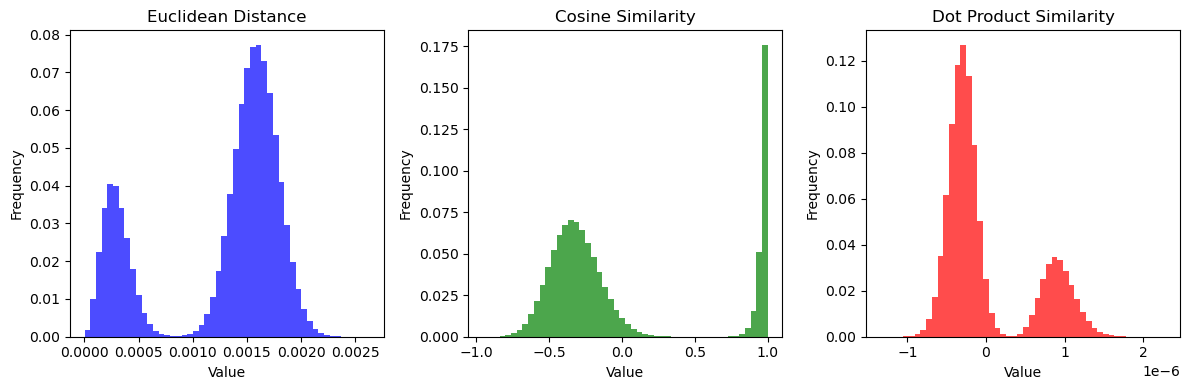

In [46]:
emb = create_embedding(G, emb_params = {
                                    "method": "leigenmap",
                                    "window_length": 10,
                                    "walk_length": 80, #30,
                                    "num_walks": 10, #200,
                                    "dim" : n_communities-1 #128,
                                        })
normalized_emb = emb / np.linalg.norm(emb, axis=1, keepdims=True)

distances = compute_node_distances(emb)

plot_distributions(distances['euclidean_distances'], 
                   distances['cosine_similarities'], 
                   distances['dot_similarities'])

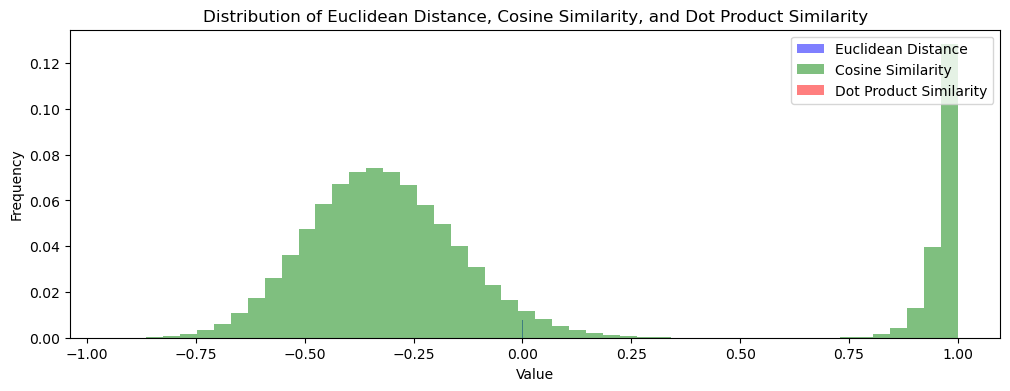

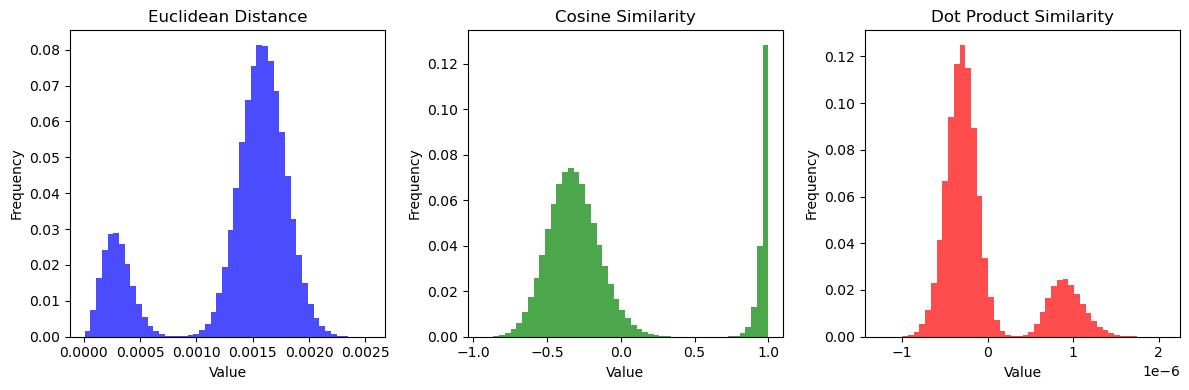

In [47]:


# Get the filtered distances for each metric
euclidean_distances_filtered = filter_condensed_distances(community_labels, distances['euclidean_distances'])
cosine_similarities_filtered = filter_condensed_distances(community_labels, distances['cosine_similarities'])
dot_similarities_filtered = filter_condensed_distances(community_labels, distances['dot_similarities'])

# Now call your original plot_distributions function to plot the filtered distances
plot_distributions(euclidean_distances_filtered,
                   cosine_similarities_filtered,
                   dot_similarities_filtered)


## Analysis for 8 well separated clusters

#### Embeddings generated through Node2Vec

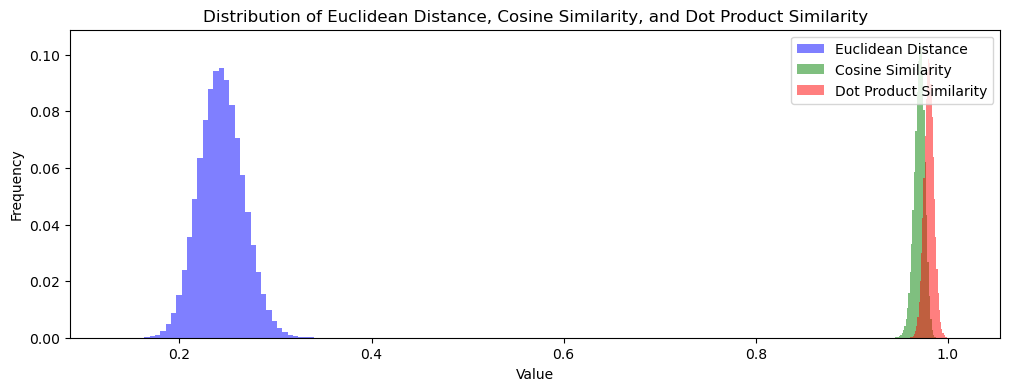

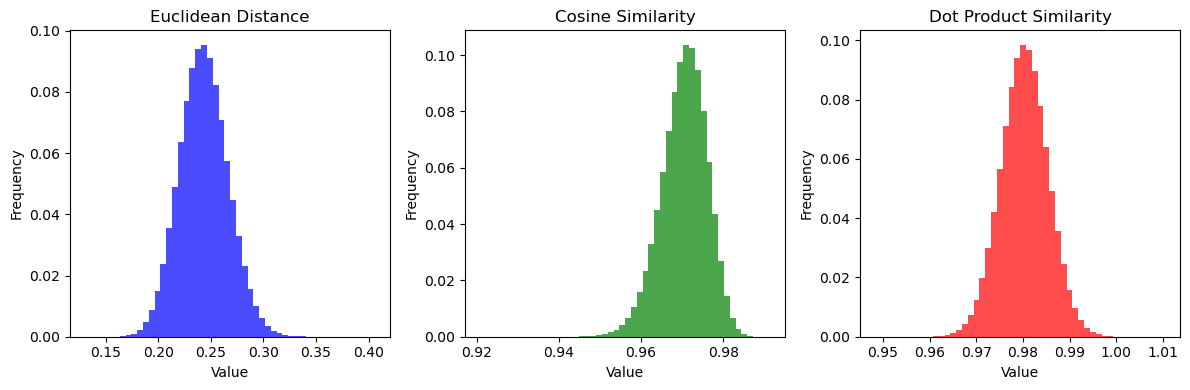

In [48]:
n_communities = 8
size = 1000*n_communities
p_intra = 0.1
p_inter = 0.04
sizes = [size // n_communities] * n_communities
p_matrix = np.full((n_communities, n_communities), p_inter)
np.fill_diagonal(p_matrix, p_intra)

G = nx.stochastic_block_model(sizes, p_matrix)
true_labels = [i for i, s in enumerate(sizes) for _ in range(s)]

community_table = pd.DataFrame({'community_id': true_labels})

emb = create_embedding(G, emb_params = {
                                    "method": "node2vec",
                                    "window_length": 10,
                                    "walk_length": 80, #30,
                                    "num_walks": 10, #200,
                                    "dim" : 64 #128,
                                        })
normalized_emb = emb / np.linalg.norm(emb, axis=1, keepdims=True)

distances = compute_node_distances(emb)

plot_distributions(distances['euclidean_distances'], 
                   distances['cosine_similarities'], 
                   distances['dot_similarities'])

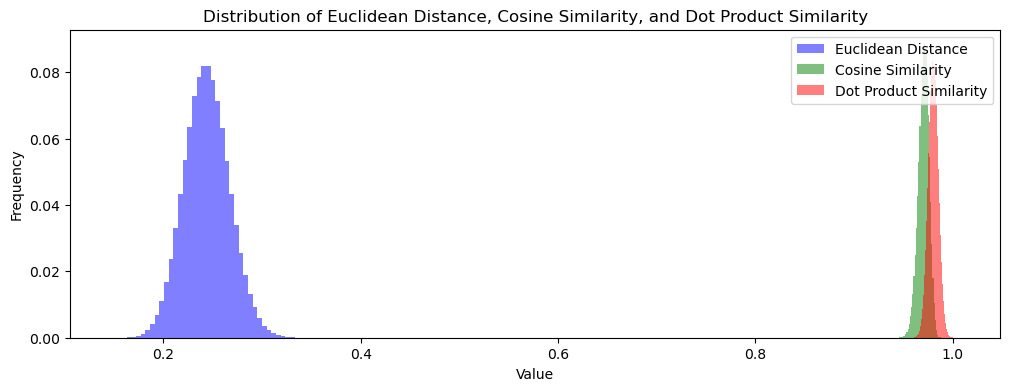

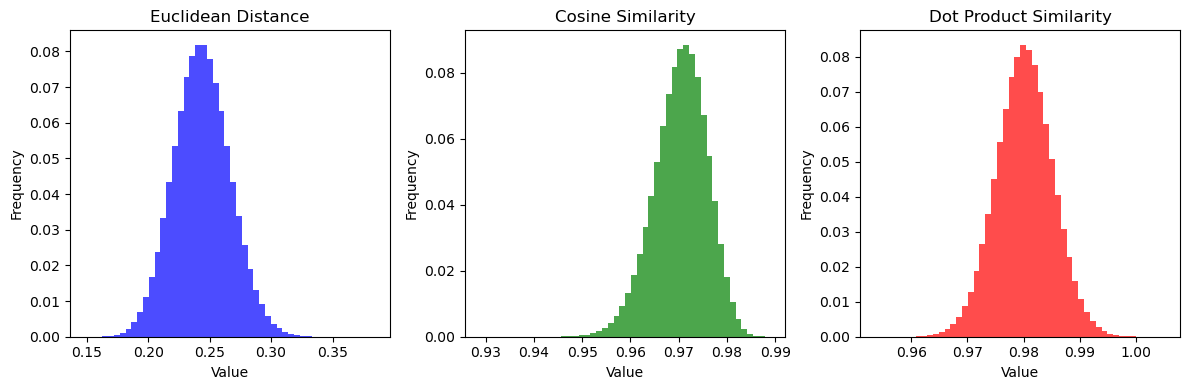

In [49]:


# Get the filtered distances for each metric
euclidean_distances_filtered = filter_condensed_distances(community_labels, distances['euclidean_distances'])
cosine_similarities_filtered = filter_condensed_distances(community_labels, distances['cosine_similarities'])
dot_similarities_filtered = filter_condensed_distances(community_labels, distances['dot_similarities'])

# Now call your original plot_distributions function to plot the filtered distances
plot_distributions(euclidean_distances_filtered,
                   cosine_similarities_filtered,
                   dot_similarities_filtered)


#### Embeddings generated through Laplacian Eigenmap

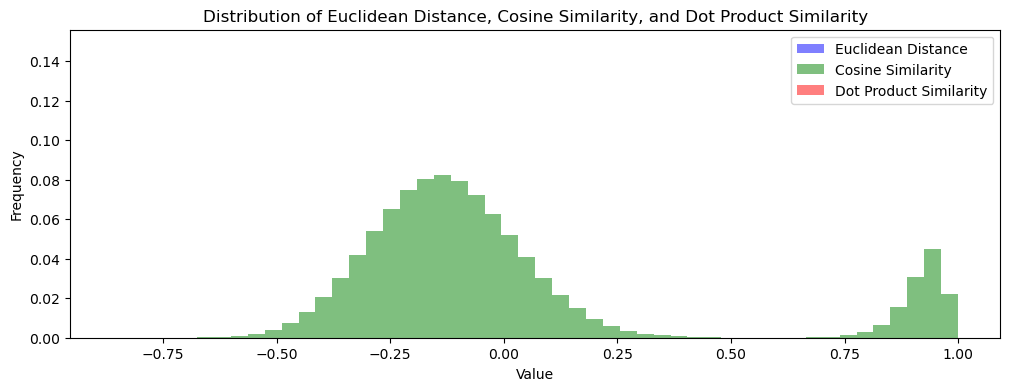

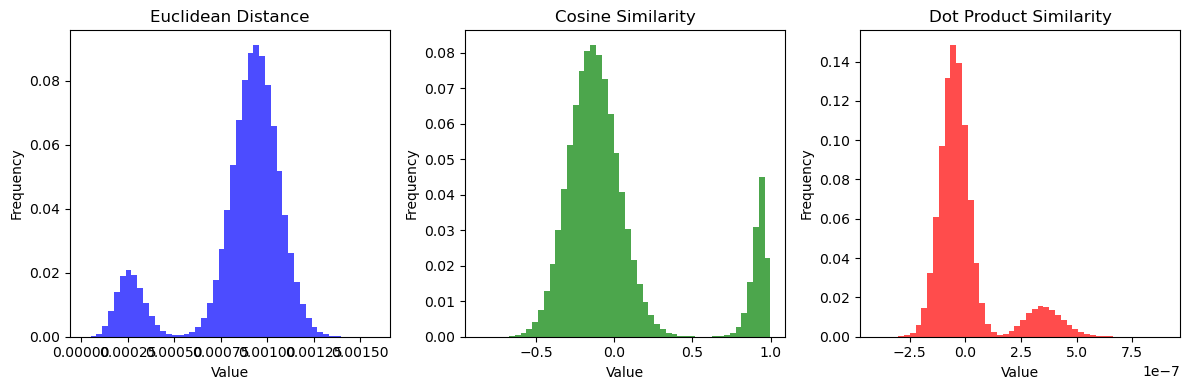

In [50]:
emb = create_embedding(G, emb_params = {
                                    "method": "leigenmap",
                                    "window_length": 10,
                                    "walk_length": 80, #30,
                                    "num_walks": 10, #200,
                                    "dim" : n_communities-1 #128,
                                        })
normalized_emb = emb / np.linalg.norm(emb, axis=1, keepdims=True)

distances = compute_node_distances(emb)

plot_distributions(distances['euclidean_distances'], 
                   distances['cosine_similarities'], 
                   distances['dot_similarities'])

The distribution is the same regardless of the number of clusters

How does the distribution look like if we only plot the pairwise distances of nodes belonging to the same community and ignore the pairwise distances of nodes in different communities 

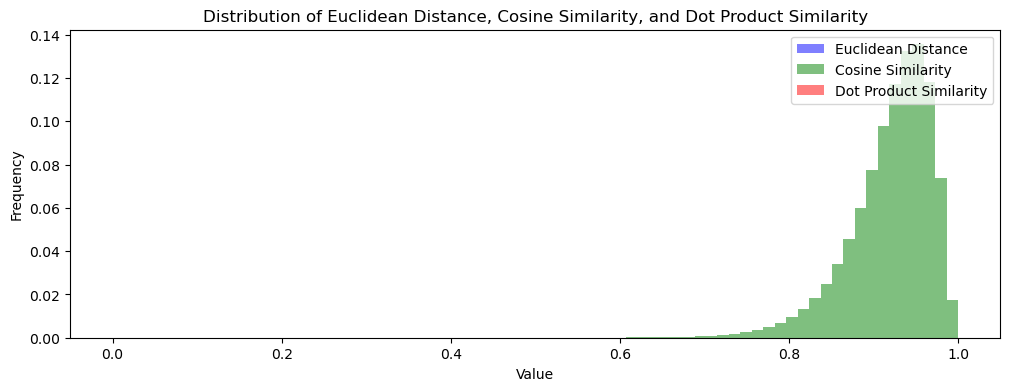

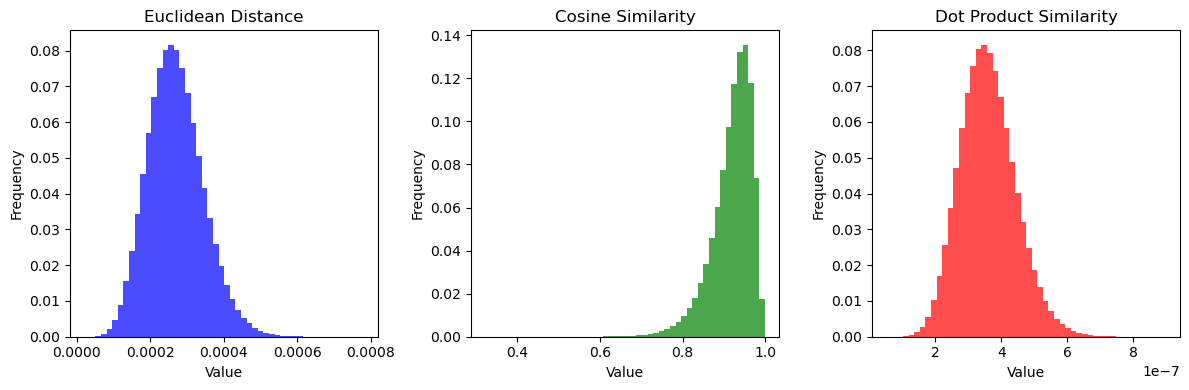

In [51]:
community_labels = community_table['community_id'].values


# Get the filtered distances for each metric
euclidean_distances_filtered = filter_condensed_distances(community_labels, distances['euclidean_distances'])
cosine_similarities_filtered = filter_condensed_distances(community_labels, distances['cosine_similarities'])
dot_similarities_filtered = filter_condensed_distances(community_labels, distances['dot_similarities'])

# Now call your original plot_distributions function to plot the filtered distances
plot_distributions(euclidean_distances_filtered,
                   cosine_similarities_filtered,
                   dot_similarities_filtered)
